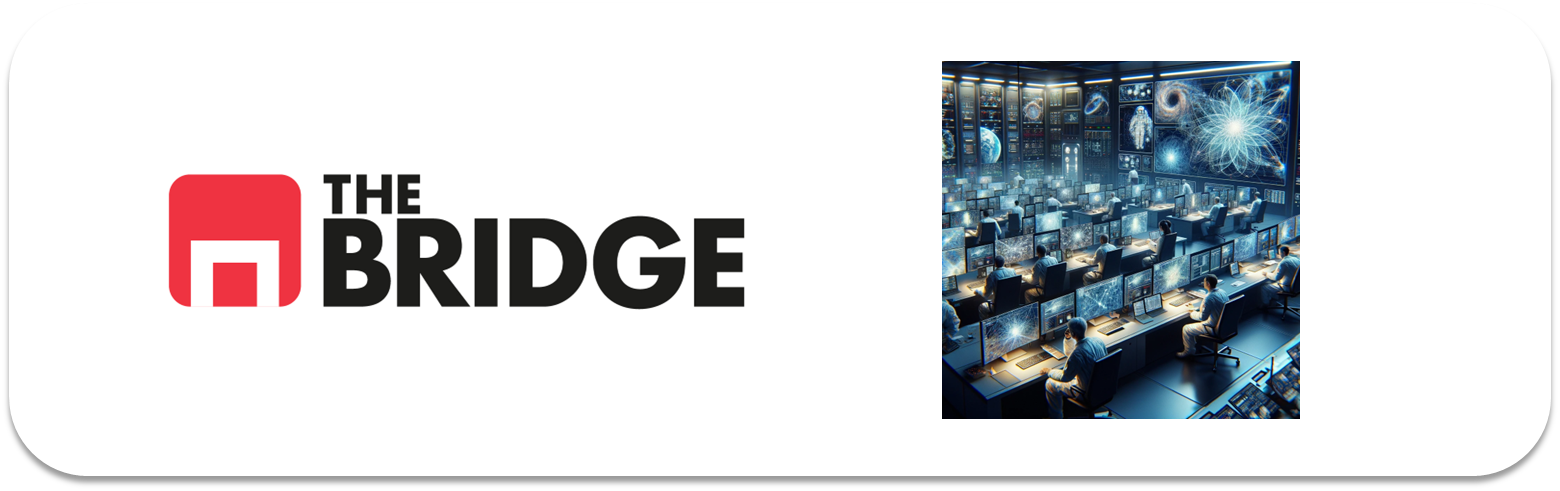

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [58]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import random

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



# 1

Preparar modelo y visualizacion

In [49]:
TRAIN_PATH = './data/seg_train/seg_train/'
filenames = os.listdir(TRAIN_PATH)
TEST_PATH = './data/seg_test/seg_test/'

In [13]:
categories = []
file_names = [] 
filepaths = []

for folder in os.listdir(TRAIN_PATH):
    
    category = folder
    if os.path.isdir(''.join([TRAIN_PATH, folder])):
        for file in os.listdir(''.join([TRAIN_PATH, folder])):

            file_names.append(file)
            categories.append(category)
            filepaths.append(TRAIN_PATH + folder + '/' + file)


In [14]:
df = pd.DataFrame({
    'filenames': file_names,
    'category': categories,
    'filepath': filepaths
})

train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [10]:
df

,filenames,category,filepath
0,0.jpg,buildings,./data/seg_train/seg_train/buildings/0.jpg
1,10006.jpg,buildings,./data/seg_train/seg_train/buildings/10006.jpg
2,1001.jpg,buildings,./data/seg_train/seg_train/buildings/1001.jpg
3,10014.jpg,buildings,./data/seg_train/seg_train/buildings/10014.jpg
4,10018.jpg,buildings,./data/seg_train/seg_train/buildings/10018.jpg
...,...,...,...
14029,9961.jpg,street,./data/seg_train/seg_train/street/9961.jpg
14030,9967.jpg,street,./data/seg_train/seg_train/street/9967.jpg
14031,9978.jpg,street,./data/seg_train/seg_train/street/9978.jpg
14032,9989.jpg,street,./data/seg_train/seg_train/street/9989.jpg


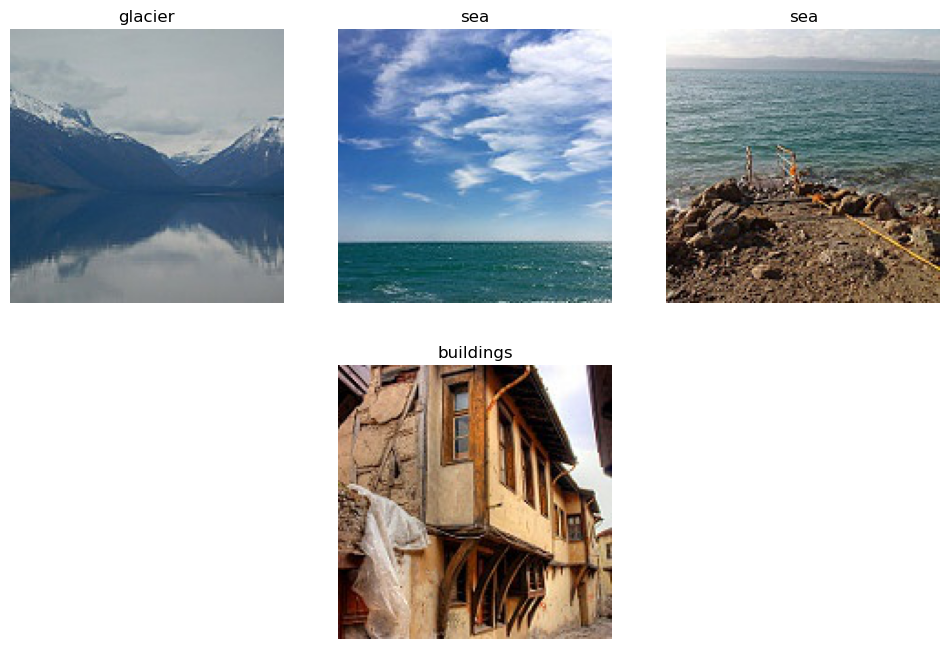

In [17]:
# Función para mostrar imágenes del conjunto de datos
def show_sample_images(df, path, num_images=6):
    plt.figure(figsize=(12, 8))
    sample = df.sample(num_images)
    for index, row in sample.iterrows():
        filepath = row['filepath']
        img = load_img(filepath, target_size=(150, 150))
        plt.subplot(2, 3, index % num_images + 1)
        plt.imshow(img)
        plt.title(row['category'])
        plt.axis('off')
    plt.show()

show_sample_images(train_df, TRAIN_PATH)

In [19]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

# Generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
validate_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# Creación de los generadores
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='category',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validate_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    x_col='filepath',
    y_col='category',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11227 validated image filenames belonging to 6 classes.
Found 2807 validated image filenames belonging to 6 classes.


In [24]:
# Definición del modelo CNN ad-hoc
model_adhoc = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 clases en total
])

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model_adhoc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history_adhoc = model_adhoc.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validate_generator,
    validation_steps=validate_generator.samples // BATCH_SIZE,
    epochs=20
)

Epoch 1/20


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 215s 604ms/step - accuracy: 0.4346 - loss: 1.4266 - val_accuracy: 0.6430 - val_loss: 0.9203
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step - accuracy: 0.6875 - loss: 0.9265 - val_accuracy: 0.5217 - val_loss: 1.0778
Epoch 3/20


c:\Users\admin\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


350/350 ━━━━━━━━━━━━━━━━━━━━ 141s 400ms/step - accuracy: 0.6013 - loss: 1.0207 - val_accuracy: 0.7162 - val_loss: 0.7880
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step - accuracy: 0.9062 - loss: 0.6141 - val_accuracy: 0.7826 - val_loss: 0.5730
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 136s 385ms/step - accuracy: 0.6615 - loss: 0.9057 - val_accuracy: 0.7381 - val_loss: 0.7162
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - accuracy: 0.8438 - loss: 0.5131 - val_accuracy: 0.9130 - val_loss: 0.4591
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 357ms/step - accuracy: 0.6913 - loss: 0.8426 - val_accuracy: 0.7468 - val_loss: 0.7049
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.5625 - loss: 1.0938 - val_accuracy: 0.6957 - val_loss: 0.6740
Epoch 9/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 130s 367ms/step - accuracy: 0.7022 - loss: 0.8020 - val_accuracy: 0.7550 - val_loss: 0.6627
Epoch 10/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 166us/step - accuracy: 0.8125 - loss: 0.7229 - va

# 2

In [38]:
from tensorflow.keras.applications import MobileNetV2

# Cargamos el modelo MobileNetV2 sin las capas superiores (no incluye la última capa de clasificación)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelamos las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

C:\Users\admin\AppData\Local\Temp\ipykernel_8068\2363109049.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [39]:
# Añadimos nuestras capas superiores personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

In [40]:
# Definimos el modelo completo
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

In [41]:
# Compilamos el modelo
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Entrenamos el modelo
history_mobilenet = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validate_generator,
    validation_steps=validate_generator.samples // BATCH_SIZE,
    epochs=20
)


C:\Users\admin\AppData\Local\Temp\ipykernel_8068\1753002443.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 104s 282ms/step - accuracy: 0.7050 - loss: 0.8694 - val_accuracy: 0.8825 - val_loss: 0.3244
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.9375 - loss: 0.2538 - val_accuracy: 0.8261 - val_loss: 0.4014
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 99s 281ms/step - accuracy: 0.8162 - loss: 0.5053 - val_accuracy: 0.8811 - val_loss: 0.3150
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.7812 - loss: 0.4913 - val_accuracy: 0.9565 - val_loss: 0.1387
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 272ms/step - accuracy: 0.8210 - loss: 0.4844 - val_accuracy: 0.8894 - val_loss: 0.3069
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.8438 - loss: 0.4042 - val_accuracy: 0.9130 - val_loss: 0.2369
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 271ms/step - accuracy: 0.8309 - loss: 0.4570 - val_accuracy: 0.8915 - val_loss: 0.2932
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━

# 3

Transfer-learning

In [50]:
# Inicializamos listas para almacenar información de los archivos de test
test_filenames = []
test_categories = []
test_filepaths = []

In [51]:
for folder in os.listdir(TEST_PATH):
    category = folder
    if os.path.isdir(os.path.join(TEST_PATH, folder)):
        for file in os.listdir(os.path.join(TEST_PATH, folder)):
            test_filenames.append(file)
            test_categories.append(category)
            test_filepaths.append(os.path.join(TEST_PATH, folder, file))

In [52]:
# Creamos un DataFrame con la información recopilada
test_df = pd.DataFrame({
    'filenames': test_filenames,
    'category': test_categories,
    'filepath': test_filepaths
})


In [53]:
# Generador de datos para el conjunto de test (sin aumentación)
test_datagen = ImageDataGenerator(rescale=1./255)

In [54]:
# Generador de datos para el conjunto de test (sin aumentación)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='category',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3000 validated image filenames belonging to 6 classes.


In [42]:
# Añadimos una cabeza de salida personalizada con como máximo 2 capas densas ocultas y una capa de salida
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

In [43]:
model_transfer = Model(inputs=base_model.input, outputs=predictions)

In [45]:
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Entrenamos el modelo
history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validate_generator,
    validation_steps=validate_generator.samples // BATCH_SIZE,
    epochs=10
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 108s 294ms/step - accuracy: 0.6212 - loss: 1.0655 - val_accuracy: 0.8664 - val_loss: 0.3630
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7500 - loss: 0.4804 - val_accuracy: 0.9130 - val_loss: 0.2936
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accuracy: 0.7889 - loss: 0.5849 - val_accuracy: 0.8869 - val_loss: 0.3296
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.8438 - loss: 0.4062 - val_accuracy: 0.8261 - val_loss: 0.3987
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accuracy: 0.8137 - loss: 0.5320 - val_accuracy: 0.8829 - val_loss: 0.3384
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.8750 - loss: 0.3805 - val_accuracy: 0.9565 - val_loss: 0.1558
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 103s 293ms/step - accuracy: 0.8221 - loss: 0.5082 - val_accuracy: 0.8872 - val_loss: 0.3131
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.7812 - loss: 0

In [55]:
test_loss, test_accuracy = model_transfer.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Loss en el conjunto de test: {test_loss}")
print(f"Accuracy en el conjunto de test: {test_accuracy}")

 1/93 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9375 - loss: 0.1744

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 317ms/step - accuracy: 0.9200 - loss: 0.2290
Loss en el conjunto de test: 0.3070452809333801
Accuracy en el conjunto de test: 0.8928091526031494


In [56]:
# Obtener las predicciones en el conjunto de test
Y_pred = model_transfer.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step


In [59]:
# Generar el reporte de clasificación
print('Reporte de Clasificación:')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.86      0.93      0.89       437
      forest       0.98      1.00      0.99       474
     glacier       0.83      0.85      0.84       553
    mountain       0.85      0.81      0.83       525
         sea       0.93      0.91      0.92       510
      street       0.93      0.87      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.90      0.89      3000
weighted avg       0.89      0.89      0.89      3000



In [60]:
cm = confusion_matrix(test_generator.classes, y_pred)


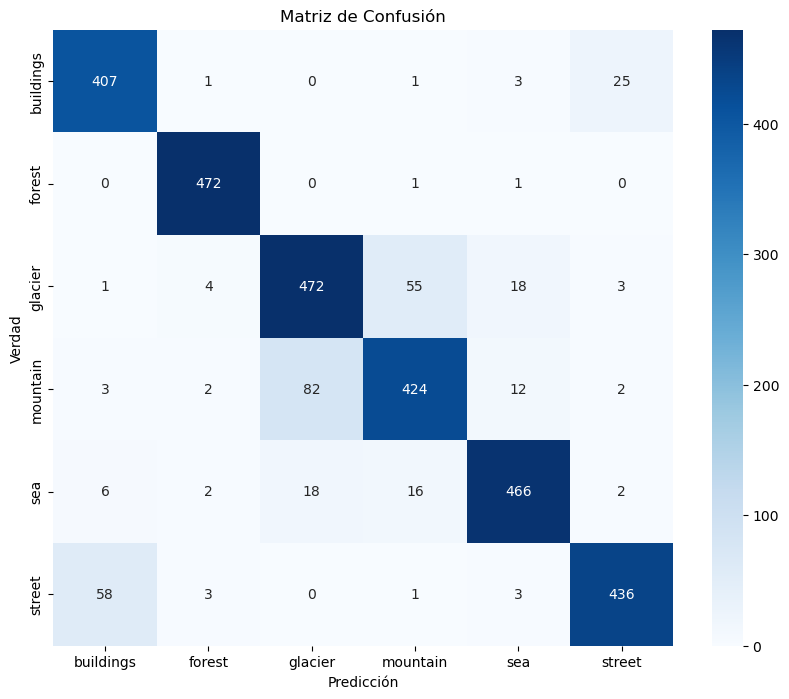

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.show()

In [1]:
pip install tensorflow_hub

  Obtaining dependency information for tensorflow_hub from https://files.pythonhosted.org/packages/e5/50/00dba77925bf2a0a1e45d7bcf8a69a1d2534fb4bb277d9010bd148d2235e/tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for protobuf>=3.19.6 from https://files.pythonhosted.org/packages/6a/8b/8a1141b09d36840ef7ee3d98482649bd9517926d3d941adfe81e00397044/protobuf-5.27.1-cp310-abi3-win_amd64.whl.metadata
  Obtaining dependency information for tf-keras>=2.14.1 from https://files.pythonhosted.org/packages/75/aa/cf09f8956d4f276f655b13674e15d8d6015fd832f9689aa9ff2a515781ab/tf_keras-2.16.0-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow<2.17,>=2.16 from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a